### Preliminaries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
from ipywidgets import interact, IntSlider
from mpl_toolkits.mplot3d import Axes3D  # needed for 3d projection

%matplotlib widget

### Coordinate detection

In [2]:
def detect_dots(image_path):
    """
    Detect neon-green or red dots in an image using HSV thresholding + connected components.
    Creates an annotated image with numbered points and saves the coordinates to a CSV file.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")

    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # If image is rubik's cube
    if os.path.basename(image_path)[1] == 'r': 
        # Define HSV threshold range for red points; Note: red wraps around the hue range
        lower_red1 = np.array([0, 150, 150])
        upper_red1 = np.array([5, 255, 255])

        lower_red2 = np.array([170, 150, 150])
        upper_red2 = np.array([179, 255, 255])

        # Create masks for both red ranges
        mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

        # Combine masks
        mask = cv2.bitwise_or(mask1, mask2)

    #Image is tsai board 
    else:
        # Define HSV threshold range for neon green points
        lower_green = np.array([40, 100, 100])
        upper_green = np.array([80, 255, 255])

        # Apply threshold
        mask = cv2.inRange(hsv, lower_green, upper_green)

    # Morphological cleaning
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Connected components
    num, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

    points = []
    for i in range(1, num):  # skip background
        cx, cy = centroids[i]
        points.append((int(cx), int(cy)))

    df = pd.DataFrame(points, columns=["x0", "y0"])

    for i, (x, y) in enumerate(points):  
        # Draw a circle for the point
        cv2.circle(img, (x, y), radius=5, color=(0, 255, 0), thickness=-1)
        # Put text next to the point
        cv2.putText(img, str(i), (x+10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 
                2, (0, 0, 255), 3)

    # Save detected image in "detectedpics" folder
    filename = os.path.basename(image_path)
    imgname = os.path.splitext(filename)[0]
    output_folder = "detectedpics"
    os.makedirs(output_folder, exist_ok=True)
    img_out_path = os.path.join(output_folder, f"det_{imgname}.jpg")
    cv2.imwrite(img_out_path, img)


    #cv2.imshow("Annotated", img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    csv_path = os.path.join("detections", f"{imgname}.csv")
    df.to_csv(csv_path, index=False)
    return df.head()

In [3]:
for files in os.listdir('pics2'): #renamed folder 'pics2' to avoid conflict with origin/main
    if files.endswith('.jpg'):
        detect_dots(os.path.join('pics2', files))



In [4]:
print(pd.read_csv('detections/3r.csv').head())

    x0    y0
0  436  1323
1  520  1329
2  598  1351
3  670  1354
4  575  1368


In [5]:
def draw_surface(x2, x1, elev=30, azim=45):
    title = f'b = {b} mm'
    Z = b * f / (x2 - x1)
    grid_x, grid_y = np.mgrid[min(x1.flatten()):max(x1.flatten()):200j, min(y.flatten()):max(y.flatten()):200j]
    grid_z = griddata((x1.flatten(), y.flatten()), Z.flatten(), (grid_x, grid_y), method='linear')
    
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(
        grid_x, grid_y, grid_z,
        cmap='viridis',
        edgecolor='black',
        linewidth=0.3,
        antialiased=True
    )

    ax.scatter(x1, y, Z, color='red', s=20)

    for i in range(len(x1)):
        ax.text(x1[i] + 1, y[i] + 1, Z[i], str(i), color='black', fontsize=8)
    
    ax.set_xlabel("x (px)")
    ax.set_ylabel("y (px)")
    ax.set_zlabel("Depth z (mm)")
    ax.set_title(title)

    

    ax.view_init(elev=0, azim=90)
    ax.invert_yaxis()
    ax.invert_xaxis()

## 3D Recreation with Surface

In [6]:
# focal length of camera
f = 5 # in mm
# camera transverse distance
b = 6*25.4 # in mm
# position of points in reference images

# Note: Convert x1-x2 into mm
x1 = pd.read_csv('detections/rescaled_3.csv')['x0'].to_numpy() #always use 'rescaled_3.csv' as reference. I did not update '3.jpg'
y = pd.read_csv('detections/rescaled_3.csv')['y0'].to_numpy()
scalefactor = 1000/(x1[23]-x1[22]) # mm/px; x[23]-x[22] is diagonal of top rectangle in the box

### Image 3 and 5

[-169 -178 -136 -157 -161 -133 -157 -159 -136 -155 -158 -132 -154 -155
 -133 -153 -154 -129 -151 -149 -130 -152 -137 -143 -133 -142 -153 -149
 -151 -135 -139 -150 -148 -151 -138 -141 -148 -150 -148 -160 -171]


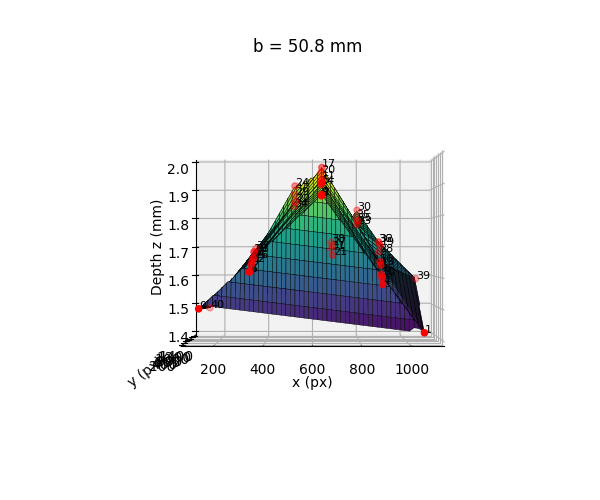

In [7]:
x2 = pd.read_csv('detections/5.csv')['x0'].to_numpy()
b = 2*25.4
# Manually adjust to match points
misaligned_indices = [39,40,36,37,32,30,31,33,27,25,26,21,22]
correct_indices = [40,39,37,36,33,31,30,32,26,27,25,22,21]

x2[40], x2[39] = x2[39], x2[40]
x2[37], x2[36] = x2[36], x2[37]
x2[33], x2[31], x2[30], x2[32] = x2[32], x2[30], x2[31], x2[33]
x2[26], x2[27], x2[25] = x2[27], x2[25], x2[26]
x2[22], x2[21] = x2[21], x2[22]

# Create interactive sliders
interact(
    draw_surface(x2,x1),
    elev=IntSlider(min=0, max=90, step=1, value=35, description='Elevation'),
    azim=IntSlider(min=0, max=360, step=1, value=70, description='Azimuth'),
)

print(x1-x2)

### Image 3 and 4

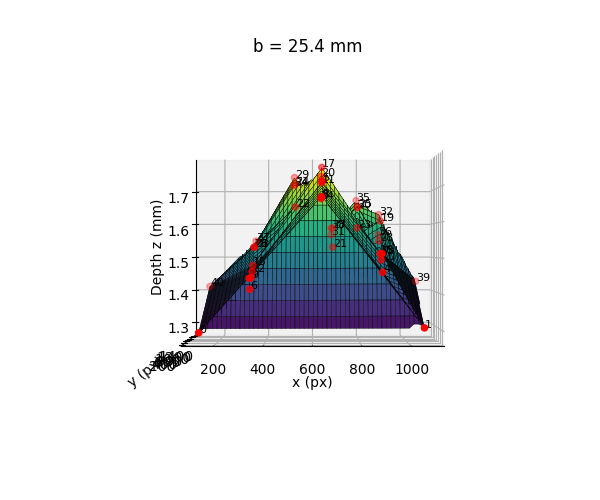

In [8]:
#Try it for image 4
x2 = pd.read_csv('detections/4.csv')['x0'].to_numpy()
b = 25.4
# Manually adjust to match points
misaligned_indices = [36,37,38,32,30,31,33,27,25,26,21,22]
correct_indices = [37,38,36,33,31,30,32,26,27,25,22,21]

x2[37], x2[38], x2[36] = x2[36], x2[37], x2[38]
x2[33], x2[31], x2[30], x2[32] = x2[32], x2[30], x2[31], x2[33]
x2[26], x2[27], x2[25] = x2[27], x2[25], x2[26]
x2[22], x2[21] = x2[21], x2[22]


# Create interactive sliders
interact(
    draw_surface(x2,x1),
    elev=IntSlider(min=0, max=90, step=1, value=35, description='Elevation'),
    azim=IntSlider(min=0, max=360, step=1, value=70, description='Azimuth'),
)

### Image 3 and 6

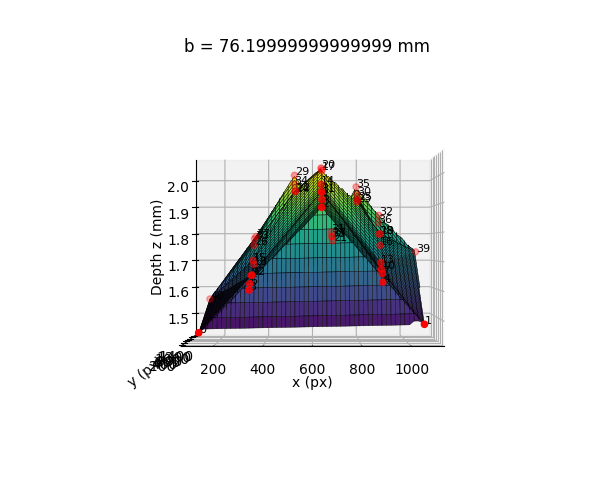

In [9]:
#Try it for image 6
x2 = pd.read_csv('detections/6.csv')['x0'].to_numpy()
title = "Vs. 6"
b = 3*25.4
# Manually adjust to match points
misaligned_indices = [38,36,37,39,40,31,32,33,24,25,26,21,23,22,20,19]
correct_indices = [40,37,38,36,39,33,31,32,26,24,25,22,21,23,19,20]

x2[40], x2[37], x2[38], x2[36], x2[39] = x2[38], x2[36], x2[37], x2[39], x2[40]
x2[33], x2[31], x2[32] = x2[31], x2[32], x2[33]
x2[26], x2[24], x2[25] = x2[24], x2[25], x2[26]
x2[22], x2[21], x2[23] = x2[21], x2[23], x2[22]
x2[19], x2[20] = x2[20], x2[19]


# Create interactive sliders
interact(
    draw_surface(x2,x1),
    elev=IntSlider(min=0, max=90, step=1, value=35, description='Elevation'),
    azim=IntSlider(min=0, max=360, step=1, value=70, description='Azimuth'),
)



### Image 3 and 7

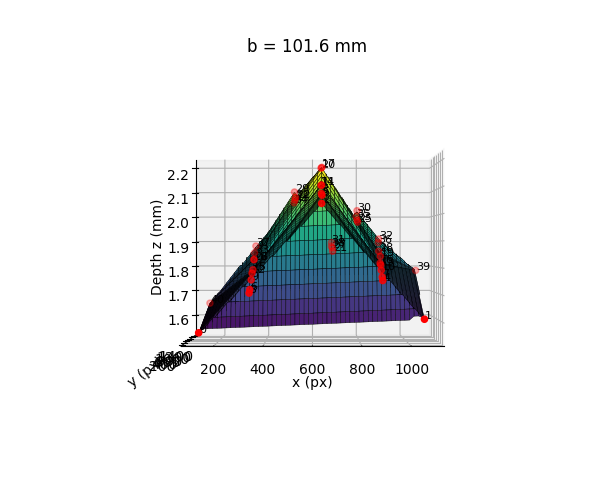

In [10]:
#Try it for image 7
x2 = pd.read_csv('detections/7.csv')['x0'].to_numpy()
b = 4*25.4
title = f'b = {b} mm'

# Manually adjust to match points
misaligned_indices = [39,40,36,37,38,33,32,30,25,26,27,22,21]
corr_indices = [40,39,37,38,36,32,30,33,26,27,25,21,22]

x2[40], x2[39], x2[37], x2[38], x2[36] = x2[39], x2[40], x2[36], x2[37], x2[38]
x2[32], x2[30], x2[33] = x2[33], x2[32], x2[30]
x2[26], x2[27], x2[25] = x2[25], x2[26], x2[27]
x2[21], x2[22] = x2[22], x2[21]

# Create interactive sliders
interact(
    draw_surface(x2,x1),
    elev=IntSlider(min=0, max=90, step=1, value=35, description='Elevation'),
    azim=IntSlider(min=0, max=360, step=1, value=70, description='Azimuth'),
)


### Images 3 and 8

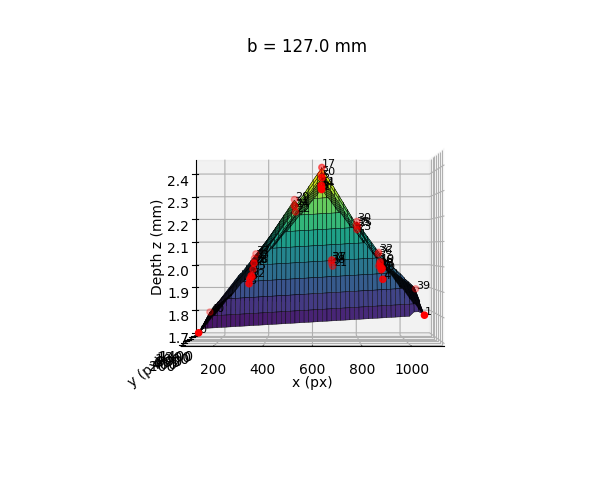

In [11]:
#Try it for image 8
x2 = pd.read_csv('detections/8.csv')['x0'].to_numpy()
b = 5*25.4

# Manually adjust to match points
misaligned_indices = [39,40,36,37,38,33,31,30,32,27,25,21,22]
corr_indices = [40,39,37,38,36,32,30,31,33,25,27,22,21]

x2[40], x2[39], x2[37], x2[38], x2[36] = x2[39], x2[40], x2[36], x2[37], x2[38]
x2[32], x2[30], x2[31], x2[33] = x2[33], x2[31], x2[30], x2[32]
x2[25], x2[27] = x2[27], x2[25]
x2[22], x2[21] = x2[21], x2[22]

# Create interactive sliders
interact(
    draw_surface(x2,x1),
    elev=IntSlider(min=0, max=90, step=1, value=35, description='Elevation'),
    azim=IntSlider(min=0, max=360, step=1, value=70, description='Azimuth'),
)


### Images 3 and 9

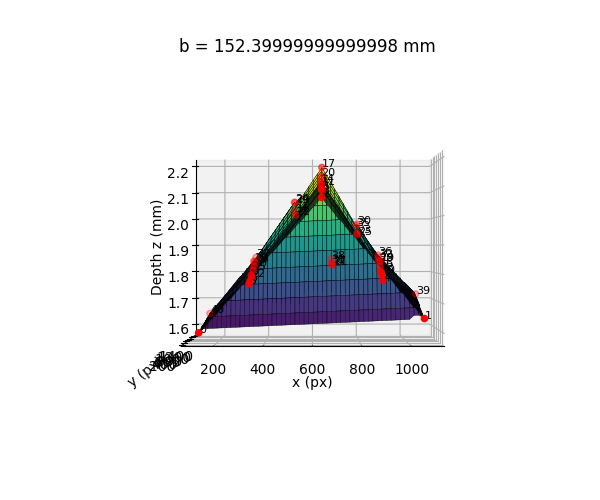

In [12]:
x2 = pd.read_csv('detections/9.csv')['x0'].to_numpy()
b = 6*25.4 #mm

# Manually adjust to match points
x2[39], x2[40] = x2[40], x2[39]
x2[37], x2[38], x2[36] = x2[36], x2[37], x2[38]
x2[33], x2[31], x2[30], x2[32] = x2[31], x2[30], x2[32], x2[33]
x2[25], x2[26] = x2[26], x2[25]
x2[21], x2[22] = x2[22], x2[21]

# Create interactive sliders
interact(
    draw_surface(x2,x1),
    elev=IntSlider(min=0, max=90, step=1, value=35, description='Elevation'),
    azim=IntSlider(min=0, max=360, step=1, value=70, description='Azimuth'),
)